In [61]:
import math

import pandas as pd
from itertools import combinations
from scipy.cluster import hierarchy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import hypergeom
from sklearn.preprocessing import StandardScaler
from collections import Counter
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceMatrix, DistanceTreeConstructor
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import plotly.express as px

In [21]:
# Read psychiatric files into dataframes
adhd = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_ADHD.txt', sep='\t')
asd = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_ASD.txt', sep='\t')
anorexia = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_ANOREXIA.txt', sep='\t')
anxiety = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_ANXIETY.txt', sep='\t')
aud = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_AUD.txt', sep='\t')
bpd = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_BPD.txt', sep='\t')
cud = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_CUD.txt', sep='\t')
hoarding = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_HOARDING.txt', sep='\t')
mdd = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_MDD.txt', sep='\t')
ocd = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_OCD.txt', sep='\t')
od = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_OD.txt', sep='\t')
ptsd = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_PTSD.txt', sep='\t' )
scz = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_SCZ.txt', sep='\t')
tourette = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_TOURETTES.txt', sep='\t')



In [ ]:
# sjogrens = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_SJOGRENS.txt', sep='\t')
# lupus = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_LUPUS.txt', sep='\t')
# biliary_chorrhosis = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_BILIARY.txt', sep='\t')
# myasthenia = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_MYASTHENIA.txt', sep='\t')
# rh_arthritis = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_ARTHRITIS.txt', sep='\t')
# ms = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_MS.txt', sep='\t')
# parkinsons = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_PARKINSONS.txt', sep='\t')
# migraine = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_MIGRAINE.txt', sep='\t')
# fibromyalgia = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_FIBROMYLGIA.txt', sep='\t')
# fatigue = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_FATIGUE.txt', sep='\t')
# ibs = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_IBS.txt', sep='\t')
# gout = pd.read_csv('FUMA_downloads_all_tissue/SNPs/snps_GOUT.txt', sep='\t')

In [22]:
# Lists of all dataframes
psych = [adhd, asd, anorexia, anxiety, aud, bpd, cud, hoarding, mdd, ocd, od, ptsd, scz, tourette]
# other = [epilepsy, sjogrens, lupus, biliary_chorrhosis, myasthenia, rh_arthritis, ms, parkinsons,migraine, fibromyalgia, fatigue, ibs, gout]
#lists of disorder names
psych_names = ['adhd', 'asd', 'anorexia', 'anxiety', 'aud', 'bpd', 'cud', 'hoarding', 'mdd', 'ocd', 'od', 'ptsd', 'scz', 'tourette']
other_names = ['epilepsy','sjogrens', 'lupus', 'biliary_chorrhosis', 'myasthenia', 'rh_arthritis', 'ms', 'parkinsons','migraine', 'fibromyalgia', 'fatigue', 'ibs', 'gout']

In [23]:
def clean_data(df_list, disorder_names_list):
    
    #Add a column with the name of the disorder in each dataframe
    for df, name in zip(df_list, disorder_names_list):
        df['disorder'] = name

    
    new_df_list =[]
    # Removing rows with NaN values and selecting relevant columns
    for df in df_list:
        df.dropna(subset=['gwasP'], inplace=True)
        df = df[['uniqID', 'rsID', 'gwasP', 'disorder']]
        new_df_list.append(df)
        
    return new_df_list


In [24]:
dfs_psych = clean_data(psych, psych_names)
# dfs_other = clean_data(other, other_names)
# dfs_all = dfs_psych + dfs_psych

In [25]:
#Function to make binary matrix of SNPs and disorders
def make_binary_SNPs_matrix(df_list):
    concatenated= pd.concat(df_list)
    df = concatenated[['rsID', 'disorder']]
    return df.pivot_table(index='rsID', columns='disorder', aggfunc=lambda x: 1, fill_value=0)
    

In [26]:
#Make a binary matrix of all snps to find out how many there are in each disorder
snps_psych_binary = make_binary_SNPs_matrix(dfs_psych)
# snps_other_binary = make_binary_SNPs_matrix(dfs_other)
# print('The number of SNPs shared between at least 2 disorders: ', (snps_psych_binary.sum(axis=1) >= 2).sum())
print(snps_psych_binary.sum(axis=0))

disorder
adhd         7018
anorexia     2562
anxiety        84
asd          4006
aud          5984
bpd         27077
cud           719
hoarding       79
mdd         15332
ocd           130
od            151
ptsd          186
scz         41691
tourette      292
dtype: int64


In [ ]:
# Function to make binary matrix of genes and disorders
def make_binary_genes_matrix(df_list):
    concatenated= pd.concat(df_list)
    df = concatenated[['symbol', 'disorder']]
    return df.pivot_table(index='symbol', columns='disorder', aggfunc=lambda x: 1, fill_value=0)

In [27]:
#Function to select the top SNPs ranked by significance
def select_top_snps(df_list, no_of_snps):
    new_df_list = []
    for df in df_list:
        sorted_df = df.sort_values(by=['gwasP'])
        new_df = sorted_df.iloc[:no_of_snps]
        new_df.reset_index(inplace=True, drop=True)
        new_df_list.append(new_df)
    return new_df_list

In [28]:
top_psych = select_top_snps(dfs_psych, 100)
# top_other = select_top_snps(dfs_other, 150)
# top_all = select_top_snps(dfs_all, 100)

In [30]:
top_psych[10]

,uniqID,rsID,gwasP,disorder
0,4:42139132:A:G,rs9291211,7.156000e-08,od
1,5:53086277:C:T,rs146361196,1.615000e-07,od
2,5:53073672:A:T,rs2221387,2.223000e-07,od
3,3:14687991:C:G,rs9310456,2.444000e-07,od
4,3:14689966:C:T,rs2278368,3.532000e-07,od
...,...,...,...,...
95,18:36316723:A:G,rs1866525,6.595000e-06,od
96,13:52404125:C:T,rs9591433,6.655000e-06,od
97,5:40642741:A:G,rs199642737,6.657000e-06,od
98,12:15118854:C:T,rs12298374,6.742000e-06,od


In [31]:
#Read in table of uniqueIDs and their corresponding genes
unique_id_genes = pd.read_csv('uniqueID_genes.txt', sep='\t', index_col=0)
# unique_id_genes_other = pd.read_csv('unique_genes_other.txt', sep='\t', index_col=0)


In [ ]:
unique_id_all = unique_id_genes + unique_id_genes_other

In [32]:
def map_snps_to_genes(df_list, id_dataframe):
    #map top SNPs to its corresponding genes
    merged_dfs = []
    for dataframe in df_list:
        merged = pd.merge(dataframe, id_dataframe[['uniqID', 'symbol']], on='uniqID', how='left')
        merged = merged.drop_duplicates(subset='uniqID')
        merged_dfs.append(merged)
    return merged_dfs
    

In [33]:
top_psych_snps_and_genes = map_snps_to_genes(top_psych, unique_id_genes)
# top_other_snps_and_genes = map_snps_to_genes(top_other, unique_id_genes_other)

In [ ]:
top_snps_and_genes_all = top_psych_snps_and_genes + top_other_snps_and_genes

In [34]:
top_psych_snps = make_binary_SNPs_matrix(top_psych_snps_and_genes)
# top_psych_genes = make_binary_genes_matrix(top_psych_snps_and_genes)
# top_other_snps = make_binary_SNPs_matrix(top_other_snps_and_genes)
# top_other_genes = make_binary_genes_matrix(top_other_snps_and_genes)
# top_all_snps = make_binary_SNPs_matrix(top_snps_and_genes_all)
# top_all_genes = make_binary_genes_matrix(top_snps_and_genes_all)

In [35]:
print('The number of SNPs shared between at least 2 psychiatric disorders: ',(top_psych_snps.sum(axis=1) >= 2).sum())
# print('The number of genes shared between at least 2 psychiatric disorders: ',(top_psych_genes.sum(axis=1) >= 2).sum())
# print('The number of SNPs shared between at least 2 other disorders: ',(top_other_snps.sum(axis=1) >= 2).sum())
# print('The number of genes shared between at least 2 other disorders: ',(top_other_genes.sum(axis=1) >= 2).sum())
# print('The number of SNPs shared between at least 2 disorders: ',(top_all_snps.sum(axis=1) >= 2).sum())
# print('The number of genes shared between at least 2 disorders: ',(top_all_genes.sum(axis=1) >= 2).sum())

The number of SNPs shared between at least 2 psychiatric disorders:  39


In [36]:
#function to find the overlaps in SNPs and genes

def find_overlaps(binary_matrix):

    overlaps = []
    
    for index, row in binary_matrix.iterrows():
        ones = [col for col, val in row.items() if val == 1]
        
        if len(ones) >= 2:
            overlaps.append((index, ones))
    return overlaps      


In [37]:
overlap_snps_psych = find_overlaps(top_psych_snps)
# overlap_genes_psych = find_overlaps(top_psych_genes)
# overlap_snps_other = find_overlaps(top_other_snps)
# overlap_genes_other = find_overlaps(top_other_genes)
# overlap_snps_all = find_overlaps(top_all_snps)
# overlap_genes_all = find_overlaps(top_all_genes)

In [38]:
# function to find which snps overlaps in which disorders
def show_snps_overlaps(list_of_snps):

    #snp_list = []
    for snps, disorders in list_of_snps:
        #snp_list.append(snps)
        print(f'{snps} overlaps in {disorders}')

In [ ]:
#function to find which genes overlaps in which disorders
def show_gene_overlaps(list_of_genes):
    #gene_list = []
    for gene, disorders in list_of_genes:
        #gene_list.append(gene)
        print(f'{gene} overlaps in {disorders}')

In [39]:
show_snps_overlaps(overlap_snps_psych)


rs12202969 overlaps in ['bpd', 'tourette']
rs12206087 overlaps in ['bpd', 'tourette']
rs13195291 overlaps in ['mdd', 'scz']
rs13197176 overlaps in ['mdd', 'scz']
rs13197574 overlaps in ['mdd', 'scz']
rs13197633 overlaps in ['mdd', 'scz']
rs13203816 overlaps in ['mdd', 'scz']
rs13204012 overlaps in ['mdd', 'scz']
rs13205211 overlaps in ['mdd', 'scz']
rs13208096 overlaps in ['mdd', 'scz']
rs13214023 overlaps in ['mdd', 'scz']
rs1487441 overlaps in ['bpd', 'tourette']
rs17693963 overlaps in ['bpd', 'scz']
rs2232423 overlaps in ['mdd', 'scz']
rs2232426 overlaps in ['mdd', 'scz']
rs2232429 overlaps in ['mdd', 'scz']
rs2388334 overlaps in ['bpd', 'tourette']
rs33932084 overlaps in ['mdd', 'scz']
rs34166054 overlaps in ['mdd', 'scz']
rs34218844 overlaps in ['mdd', 'scz']
rs34243448 overlaps in ['mdd', 'scz']
rs34371502 overlaps in ['mdd', 'scz']
rs34588114 overlaps in ['mdd', 'scz']
rs35001169 overlaps in ['mdd', 'scz']
rs35017208 overlaps in ['mdd', 'scz']
rs35072899 overlaps in ['mdd', 'scz

In [40]:
# function to randomly select a given number of SNPs
def select_snps_randomly(df_list, number_of_snps):
        sampled_dfs = []
        for df in df_list:
            sampled = df.sample(n=number_of_snps, replace=True)
    
            sampled_df = sampled[['rsID', 'disorder']]
            sampled_df.reset_index(inplace=True, drop=True)
            # reset index
            #sampled_df.reset_index()
            sampled_dfs.append(sampled_df)
            
        return sampled_dfs

In [41]:
#function to make binary matrix with randobly selected snps
def make_random_binary_matrix(number_i, list_of_snps, number_of_snps):
    random_binary_list = []
    for i in range(number_i):
        random = select_snps_randomly(list_of_snps, number_of_snps)
        concatenated_random = pd.concat(random)
    
        binary = concatenated_random.pivot_table(index='rsID', columns='disorder', aggfunc=lambda x: 1, fill_value=0)
        random_binary_list.append(binary)
    return random_binary_list


In [42]:
# all_linkage = []
# 
# for i in range(10):
    
    
transposed = top_psych.T

clusters = hierarchy.linkage(transposed, method='average', metric='jaccard')
# all_linkage.append(clusters)
#Plot the dendrogram for disorders
plt.figure(figsize=(12,8))
plt.title('Hierarchical Clustering Dendrogram for Disorders')
plt.xlabel('Disorders')
plt.ylabel('Distance')
hierarchy.dendrogram(clusters, labels=transposed.index, leaf_rotation=90, leaf_font_size=12)
plt.tight_layout()
plt.show()

AttributeError: 'list' object has no attribute 'T'

In [ ]:
# # Compute the consensus linkage matrix
# consensus = np.average(all_linkage, axis=0)  
# 
# # Plot the consensus dendrogram
# plt.figure(figsize=(10, 6))
# plt.title('Consensus Dendrogram')
# plt.xlabel('Disorders')
# plt.ylabel('Distance')
# hierarchy.dendrogram(consensus,labels=psych_names,  leaf_rotation=90, leaf_font_size=14)
# plt.tight_layout()
# plt.show()

In [3]:
finngen = pd.read_csv('FinnGen/FinnGen_table_all_diseases.csv', sep=';', index_col=0)

In [80]:
disorder_list = finngen.index.values.tolist()

<Axes: >

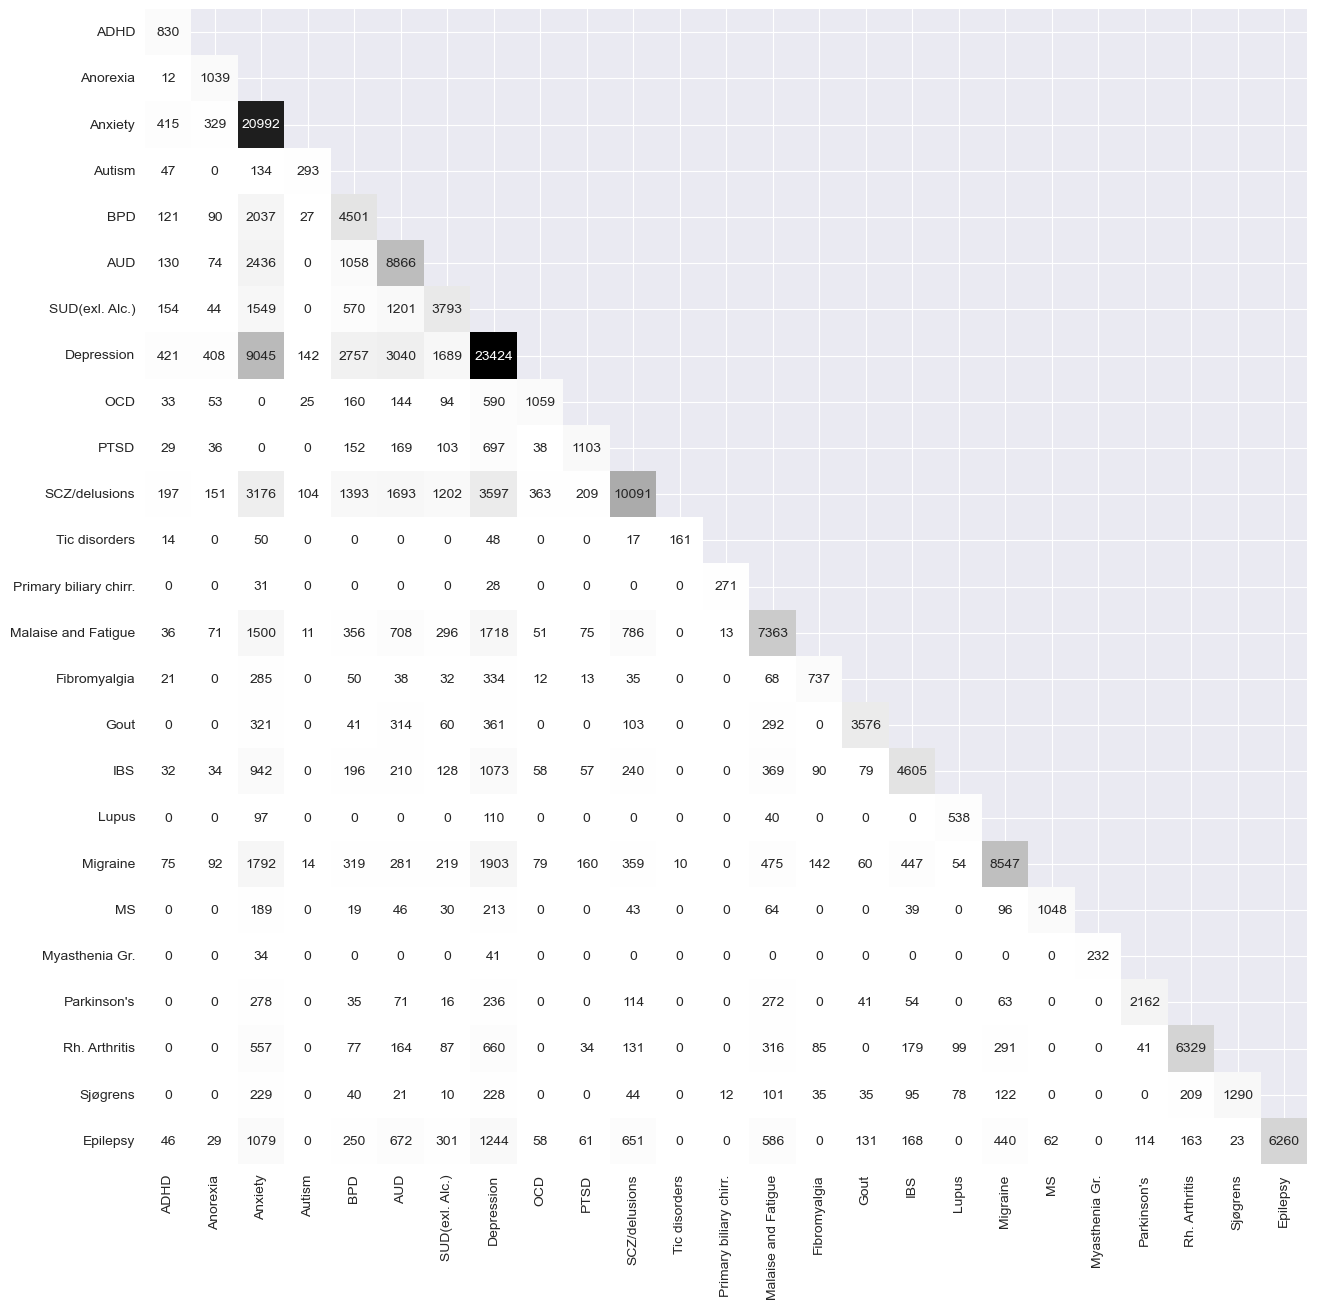

In [19]:
#specify size of heatmap
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(finngen, annot=True,fmt='.0f',cmap='Greys', cbar=False)

In [43]:

fin_matrix = finngen.to_numpy()

In [44]:
fin_matrix

array([[8.3000e+02,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan],
       [1.2000e+01, 1.0390e+03,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan],
       [4.1500e+02, 3.2900e+02, 2.0992e+04,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,   

In [45]:
print(fin_matrix.shape)

(25, 25)


In [157]:

N = 500000

fin_matrix_shape=fin_matrix.shape
prob_matrix = np.zeros(fin_matrix_shape)

for i in range(1, fin_matrix_shape[0]):
    for j in range(i):
        x =fin_matrix[i,j]
        M = fin_matrix[j,j]
        n = fin_matrix[i, i]
        #print(M,n,x)
        if M > n:
            prob = hypergeom.cdf(x, N, n, M)
            #print('M>n')
        else:
            prob = hypergeom.cdf(x, N, M, n)
            #print('n>M')
            
        prob_matrix[i,j] = prob

In [158]:
prob_df = pd.DataFrame(prob_matrix, columns=disorder_list, index=disorder_list)

In [171]:
prob_df.to_csv('finngen_prob.txt', sep='\t')

<Axes: >

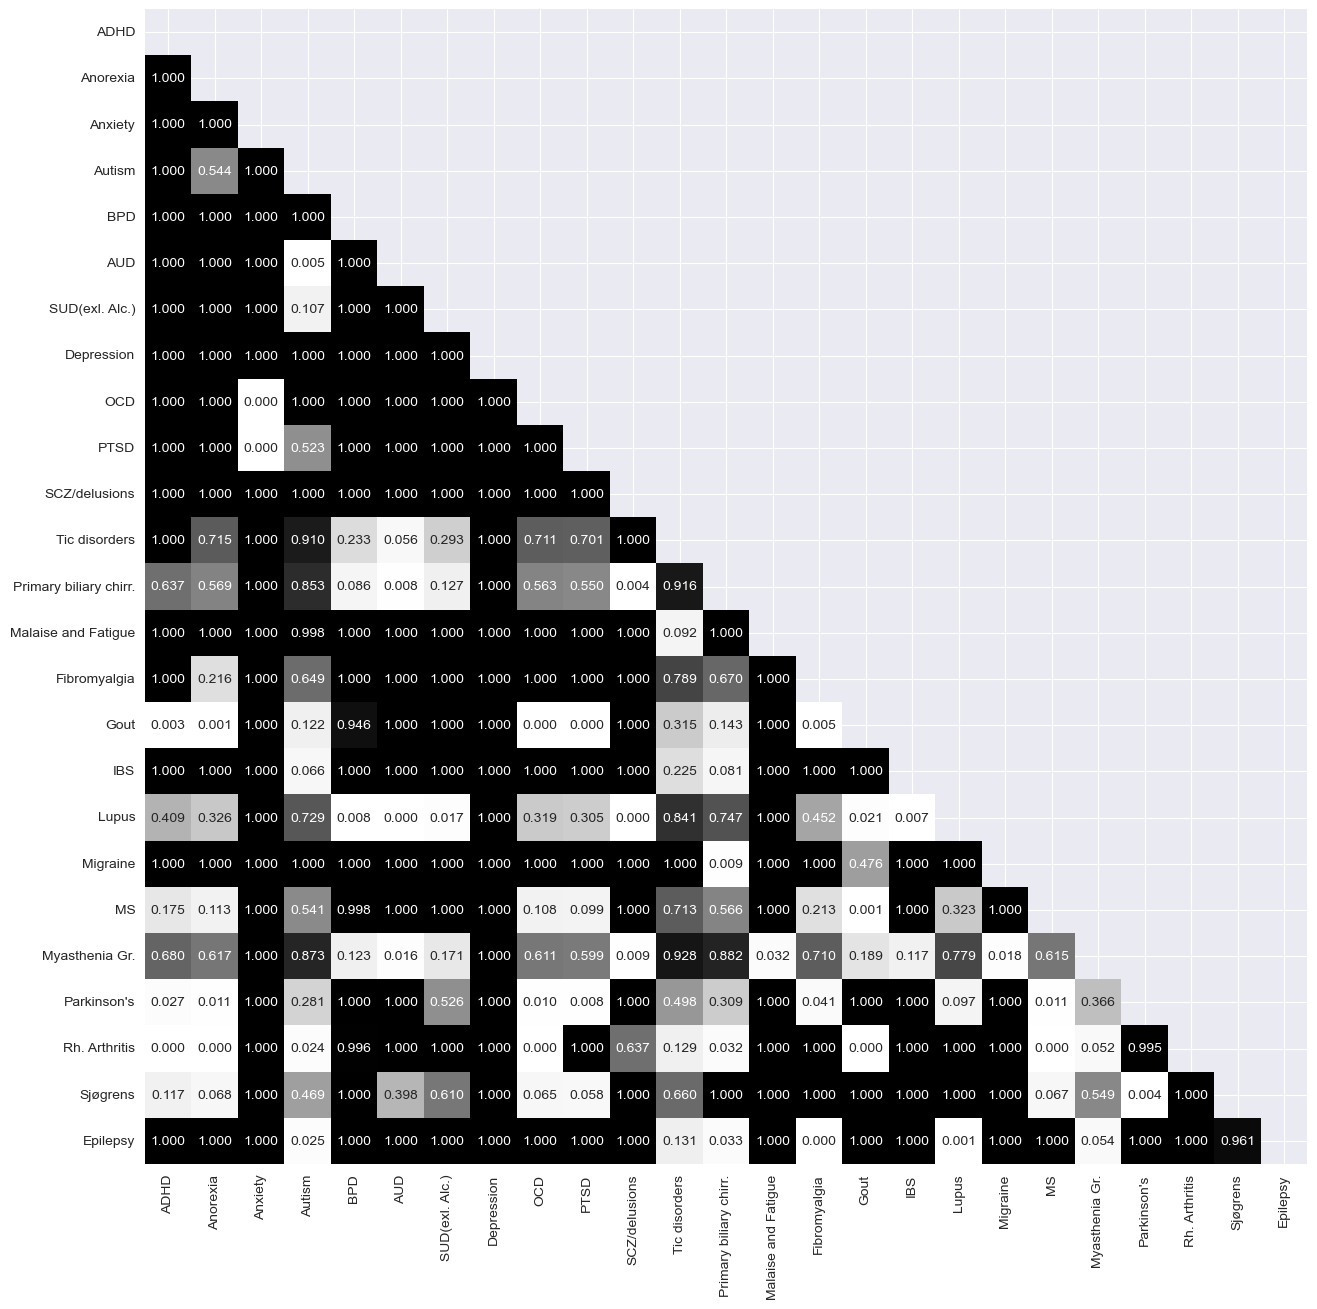

In [160]:
 #specify size of heatmap
# Create a mask for the upper triangular part
mask = np.triu(np.ones_like(prob_df, dtype=bool))

# Set the upper triangular part to NaN to exclude it from the plot
prob_df = prob_df.mask(mask)


fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(prob_df, annot=True,fmt='.3f',cmap='Greys', cbar=False)
